In [19]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
plt.style.use('/raid/lingo/akyurek/mplstyle')
plt.rc('font', serif='Times')
plt.rc('text', usetex=False)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'
"""Google cloud directory that stores results of the experiments"""
BASE_DIR = "./"
METRICS_DIR = os.path.join(BASE_DIR, "metrics")

In [20]:
def average_metrics(results):
    """Average the metrics over samples"""
    metrics = {'precision': {}, 'recall': {}}
    for k in (1, 5, 10,  50, 100):
        if type(list(results[0]['precision'].keys())[0]) == str:
            k = str(k)
        metrics['precision'][k] = np.mean([res['precision'][k] for res in results])
        metrics['recall'][k] = np.mean([res['recall'][k] for res in results])
    metrics['mrr'] = np.mean([res['rr'] for res in results])
    metrics['samples'] = results
    return metrics

In [21]:
def metrics_to_df(metrics):
    info = copy.deepcopy(metrics)
    for normalization, results in info.items():
        for method, method_results in results.items():
            for layer_config, result in method_results.items():
                if 'samples' in result:
                    if 'weights' in result['samples'][0]:
                        result['weights'] = result['samples'][0]['weights']
                del result['samples']
                result['mrr'] = {'1': result['mrr']}
                    
    df = pd.DataFrame(pd.json_normalize(info, sep="+")).transpose()
    df.index = pd.MultiIndex.from_tuples([tuple(k.split("+")) for k, v in df.iterrows()])
    df = pd.melt(df.transpose())
    df.columns = ['normalization', 'eval', 'layers', 'metrics', 'k', 'score']
    df['weight_a'] = 1.0
    df['weight_b'] = 1.0
    for i, row in df.iterrows():
        try:
            df.at[i, 'weight_a'] = info[row['normalization']][row['eval']][row['layers']]['weights'][0]
            df.at[i, 'weight_b'] = info[row['normalization']][row['eval']][row['layers']]['weights'][1]
        except:
            pass
    
    df['layer_type'] = 'A'
    df.loc[df['layers'].str.contains('gradients'), 'layer_type'] = 'gradients'
    df.loc[(df['layers'].str.contains('gradients')) & (df['layers'].str.contains('activations')), 'layer_type'] = 'gradients_and_activations'
    df.loc[(df['layers'] == 'random') | (df['layers'] == 'bm25plus'), 'layer_type'] = 'baseline'
    df = df.replace({'gradients':'G', 
                     'activations': 'A', 
                     'block.': '', 
                     'encoder': 'E', 
                     'decoder': 'D', 
                     'shared': 'Emb', 
                     'random': 'Target-Picker'}, regex=True)
    return df

In [53]:
from mpl_toolkits.mplot3d import Axes3D
def plot_a_be(df, title="", eval_type='collapse', normalization='cosine', metric="mrr", k="1"):
    df = df[(df['eval'] == eval_type) & (df['normalization'] == normalization) & (df['metrics'] == metric) & (df['k'] == k)]
    df = df[df['layers'].str.startswith('A.E.0,A.D.0')]
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection = '3d')
    ax.view_init(10, 120)
    x = df['weight_a']
    y = df['weight_b']
    z = df['score']
    ax.set_xlabel("a")
    ax.set_ylabel("b")
    ax.set_zlabel("mrr")
    ax.set_title(title)
    ax.scatter(x, y, z)
    plt.show()

In [54]:
def visualize_one_experiment(path, 
                             suffix="", 
                             folder="plots/",
                             show=True,
                             return_df=False):
  
    with open(METRICS_DIR + path) as f:
      reranker_metrics = json.load(f)
      
    df = metrics_to_df(reranker_metrics)
    df = df[(df['metrics'] != 'weights') & (df['layers'].str.startswith('A.E.0'))]
    df['score'] = df['score'].astype(float)
    # df = df[~df['layers'].str.contains('A.E.0,A.D.0,')]
    
    if return_df:
      return df
    
    plot_a_be(df, title=suffix, eval_type='collapse', normalization='cosine', metric="mrr", k="1")

In [55]:
%matplotlib inline

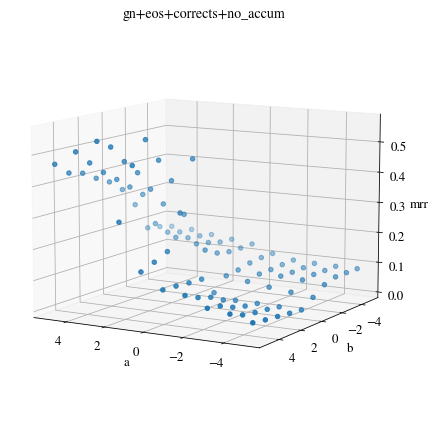

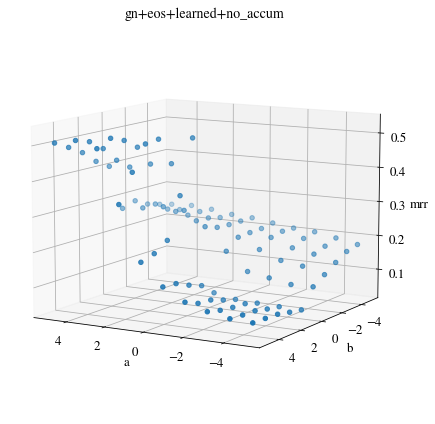

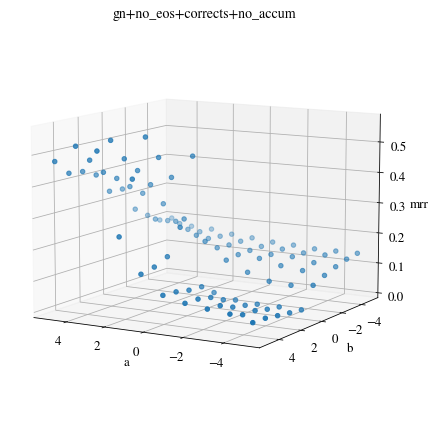

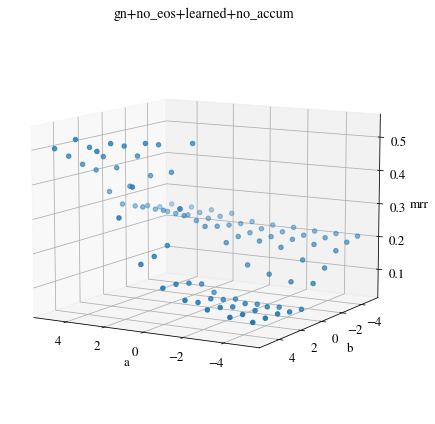

In [56]:
df = {}
for norm_type in ("gn", ):
  for eos in ("eos", "no_eos"):
    for subset in ("corrects", "learned"):
      for accum in ("no_accum",):
        try:
          suffix=f"{norm_type}+{eos}+{subset}+{accum}"
          visualize_one_experiment(path=f'/reranker/exp_interpol/{norm_type}_sl_{eos}__{subset}_{accum}.json', suffix=suffix, show=True)
        except FileNotFoundError:
          print(f'notfound: /reranker/exp_interpol/{norm_type}_sl_{eos}__{subset}_{accum}.json')

In [57]:
df = visualize_one_experiment(path=f'/reranker/exp_interpol/gn_sl_no_eos__learned_no_accum.json', suffix="test", show=False, return_df=True)
df = df[df['metrics'] == 'mrr']

In [58]:
# newdf = df[(df['metrics']!='weights') & (df['layers'].str.startswith('A.E.0'))]
# newdf['score'] = newdf['score'].astype(float) 


In [59]:
pd.options.display.max_rows = 100
df.nlargest(100, 'score')

,normalization,eval,layers,metrics,k,score,weight_a,weight_b,layer_type
1078,cosine,collapse,"A.E.0,A.D.0,G.Emb_89",mrr,1,0.533340,3.888889,5.000000,G_and_A
946,cosine,collapse,"A.E.0,A.D.0,G.Emb_78",mrr,1,0.518025,2.777778,3.888889,G_and_A
814,cosine,collapse,"A.E.0,A.D.0,G.Emb_67",mrr,1,0.514896,1.666667,2.777778,G_and_A
958,cosine,collapse,"A.E.0,A.D.0,G.Emb_79",mrr,1,0.504668,2.777778,5.000000,G_and_A
2300,cosine,full,"A.E.0,A.D.0,G.Emb_89",mrr,1,0.503205,3.888889,5.000000,G_and_A
670,cosine,collapse,"A.E.0,A.D.0,G.Emb_55",mrr,1,0.502120,0.555556,0.555556,G_and_A
802,cosine,collapse,"A.E.0,A.D.0,G.Emb_66",mrr,1,0.502120,1.666667,1.666667,G_and_A
934,cosine,collapse,"A.E.0,A.D.0,G.Emb_77",mrr,1,0.502120,2.777778,2.777778,G_and_A
1066,cosine,collapse,"A.E.0,A.D.0,G.Emb_88",mrr,1,0.502120,3.888889,3.888889,G_and_A
1198,cosine,collapse,"A.E.0,A.D.0,G.Emb_99",mrr,1,0.502120,5.000000,5.000000,G_and_A
